# ML Pipeline

## Data Preparation

In [161]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [33]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [34]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

In [35]:
df[['Papel','Tipo','Setor','Subsetor']]

,Papel,Tipo,Setor,Subsetor
24,ABCB4,PN,Intermediários Financeiros,Bancos
25,ABCB4,PN,Intermediários Financeiros,Bancos
26,ABCB4,PN,Intermediários Financeiros,Bancos
27,ABCB4,PN,Intermediários Financeiros,Bancos
28,ABCB4,PN,Intermediários Financeiros,Bancos
...,...,...,...,...
91432,ORVR3,ON,Água e Saneamento,Água e Saneamento
91457,POWE3,ON,Energia Elétrica,Energia Elétrica
91458,POWE3,ON,Energia Elétrica,Energia Elétrica
91483,WEST3,ON,Programas e Serviços,Programas e Serviços


In [36]:
df = df[df.columns.sort_values()]

In [37]:
df.head()

,Data_ult_cot,Empresa,Lucro_Liquido_12m_category,Papel,Setor,Subsetor,Tipo,besst_1,besst_2,c5y_max_max,c5y_max_ref_max,c5y_mean_last,c5y_mean_mean,c5y_mean_ref_mean,c5y_mean_ref_std,c5y_mean_std,c5y_min_min,c5y_min_ref_min,c5y_ref_spread,c5y_spread,c5y_spread_relevance,cotacao_max_max,cotacao_max_ref_max,cotacao_mean_last,cotacao_mean_mean,cotacao_mean_ref_mean,cotacao_mean_ref_std,cotacao_mean_std,cotacao_min_min,cotacao_min_ref_min,cotacao_ref_spread,cotacao_spread,cotacao_spread_relevance,divbpatr_max_max,divbpatr_max_ref_max,divbpatr_mean_last,divbpatr_mean_mean,divbpatr_mean_ref_mean,divbpatr_mean_ref_std,divbpatr_mean_std,divbpatr_min_min,divbpatr_min_ref_min,divbpatr_ref_spread,divbpatr_spread,divbpatr_spread_relevance,dolar_comercial_last,dolar_comercial_max,dolar_comercial_mean,dolar_comercial_min,dolar_comercial_spread,dolar_comercial_spread_relevance,dolar_comercial_std,dy_label,dy_max_max,dy_max_ref_max,dy_mean_last,dy_mean_mean,dy_mean_ref_mean,dy_mean_ref_std,dy_mean_std,dy_median_last,dy_median_max,dy_median_min,dy_median_ref_max,dy_median_ref_min,dy_median_ref_spread,dy_median_spread,dy_median_spread_relevance,dy_min_min,dy_min_ref_min,dy_ref_spread,dy_spread,dy_spread_relevance,euro_last,euro_max,euro_mean,euro_min,euro_spread,euro_spread_relevance,euro_std,evebit_max_max,evebit_max_ref_max,evebit_mean_last,evebit_mean_mean,evebit_mean_ref_mean,evebit_mean_ref_std,evebit_mean_std,evebit_min_min,evebit_min_ref_min,evebit_ref_spread,evebit_spread,evebit_spread_relevance,ibovespa_last,ibovespa_max,ibovespa_mean,ibovespa_min,ibovespa_spread,ibovespa_spread_relevance,ibovespa_std,igpm_last,igpm_max,igpm_mean,igpm_min,igpm_spread,igpm_spread_relevance,igpm_std,indice_da_industria_last,indice_da_industria_max,indice_da_industria_mean,indice_da_industria_min,indice_da_industria_spread,indice_da_industria_spread_relevance,indice_da_industria_std,ipca_last,ipca_max,ipca_mean,ipca_min,ipca_spread,ipca_spread_relevance,ipca_std,liq2m_max_max,liq2m_max_ref_max,liq2m_mean_last,liq2m_mean_mean,liq2m_mean_ref_mean,liq2m_mean_ref_std,liq2m_mean_std,liq2m_min_min,liq2m_min_ref_min,liq2m_ref_spread,liq2m_spread,liq2m_spread_relevance,liqc_max_max,liqc_max_ref_max,liqc_mean_last,liqc_mean_mean,liqc_mean_ref_mean,liqc_mean_ref_std,liqc_mean_std,liqc_min_min,liqc_min_ref_min,liqc_ref_spread,liqc_spread,liqc_spread_relevance,month_last,mrgebit_max_max,mrgebit_max_ref_max,mrgebit_mean_last,mrgebit_mean_mean,mrgebit_mean_ref_mean,mrgebit_mean_ref_std,mrgebit_mean_std,mrgebit_min_min,mrgebit_min_ref_min,mrgebit_ref_spread,mrgebit_spread,mrgebit_spread_relevance,mrgliq_max_max,mrgliq_max_ref_max,mrgliq_mean_last,mrgliq_mean_mean,mrgliq_mean_ref_mean,mrgliq_mean_ref_std,mrgliq_mean_std,mrgliq_min_min,mrgliq_min_ref_min,mrgliq_ref_spread,mrgliq_spread,mrgliq_spread_relevance,pa_max_max,pa_max_ref_max,pa_mean_last,pa_mean_mean,pa_mean_ref_mean,pa_mean_ref_std,pa_mean_std,pa_min_min,pa_min_ref_min,pa_ref_spread,pa_spread,pa_spread_relevance,pacl_max_max,pacl_max_ref_max,pacl_mean_last,pacl_mean_mean,pacl_mean_ref_mean,pacl_mean_ref_std,pacl_mean_std,pacl_min_min,pacl_min_ref_min,pacl_ref_spread,pacl_spread,pacl_spread_relevance,patrliq_max_max,patrliq_max_ref_max,patrliq_mean_last,patrliq_mean_mean,patrliq_mean_ref_mean,patrliq_mean_ref_std,patrliq_mean_std,patrliq_min_min,patrliq_min_ref_min,patrliq_ref_spread,patrliq_spread,patrliq_spread_relevance,pcg_max_max,pcg_max_ref_max,pcg_mean_last,pcg_mean_mean,pcg_mean_ref_mean,pcg_mean_ref_std,pcg_mean_std,pcg_min_min,pcg_min_ref_min,pcg_ref_spread,pcg_spread,pcg_spread_relevance,pebit_max_max,pebit_max_ref_max,pebit_mean_last,pebit_mean_mean,pebit_mean_ref_mean,pebit_mean_ref_std,pebit_mean_std,pebit_min_min,pebit_min_ref_min,pebit_ref_spread,pebit_spread,pebit_spread_relevance,pib_dolarizado_last,pib_dolarizado_max,pib_dolarizado_mean,pib_dolarizado_min,pib_dolarizado_spread,pib_dolarizado_spread_relevance,pib_dolarizado_std,pl_max_max,pl_max_ref_max,pl_mean_last,pl_mean_mean,pl_mean_ref_mean

In [38]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index

Index(['dy_spread_relevance', 'liq2m_ref_spread', 'liq2m_mean_ref_std',
       'liq2m_mean_ref_mean', 'liq2m_spread_relevance', 'liq2m_max_ref_max',
       'patrliq_spread_relevance', 'patrliq_ref_spread', 'patrliq_max_ref_max',
       'patrliq_mean_ref_std', 'psr_mean_ref_std', 'patrliq_mean_ref_mean',
       'psr_ref_spread', 'patrliq_max_max', 'patrliq_mean_mean',
       'patrliq_mean_last', 'patrliq_min_min', 'patrliq_spread',
       'patrliq_mean_std', 'liq2m_spread', 'pl_ref_spread', 'pl_max_ref_max',
       'liq2m_max_max', 'liq2m_mean_last', 'liq2m_mean_mean', 'liq2m_min_min',
       'liq2m_mean_std', 'pl_mean_ref_mean', 'pl_mean_ref_std',
       'psr_spread_relevance', 'pebit_spread_relevance', 'evebit_ref_spread',
       'evebit_max_ref_max', 'evebit_spread', 'pl_spread', 'pebit_spread',
       'evebit_max_max', 'pl_max_max', 'pebit_max_max', 'evebit_mean_last',
       'pl_mean_last', 'pebit_mean_last', 'pebit_ref_spread',
       'pebit_max_ref_max', 'pl_spread_relevance', 'e

In [40]:
def transform_dummy(data, features):
    """
    Transform categorical values into numerical values using one-hot encoding.
    
    Parameters:
        data (DataFrame): The DataFrame containing the categorical features to be transformed.
        features (list): List of categorical features to be transformed.
        
    Returns:
        DataFrame: The transformed DataFrame with numerical values for categorical features.
    """
    for feature in features:
        # Generate one-hot encoded columns and append to the DataFrame
        one_hot_encoded = pd.get_dummies(data[feature])
        new_columns = [(str(feature) + '_' + str(col)) for col in one_hot_encoded.columns]
        data[new_columns] = one_hot_encoded
        
        # Drop the original categorical feature from the DataFrame
        data.drop(feature, axis=1, inplace=True)
        
    return data

In [41]:
def column_name_cleaner(col):
    """
    Clean column names by replacing non-UTF-8 characters with a replacement character.

    Parameters:
        col (str): The column name to be cleaned.

    Returns:
        str: The cleaned column name.
    """
    return col.encode('utf-8', 'replace').decode('utf-8')


In [42]:
def create_year_month_column(data: pd.DataFrame, year_column: str, month_column: str) -> pd.DataFrame:
    """
    Create a new column 'year_month' in the DataFrame by concatenating values from two columns.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the columns 'year_last' and 'month_last'.
        year_column (str): Name of the column containing the year values.
        month_column (str): Name of the column containing the month values.

    Returns:
        pd.DataFrame: The DataFrame with a new 'year_month' column.
    """
    # Ensure that the specified columns exist in the DataFrame
    if year_column not in data.columns or month_column not in data.columns:
        raise ValueError(f"Columns '{year_column}' and '{month_column}' not found in the DataFrame.")
    
    # Create the 'year_month' column by concatenating the values from 'year_last' and 'month_last' columns
    data['year_month'] = data[year_column].astype(str) + data[month_column].astype(str)
    
    return data

In [43]:
df.columns = [column_name_cleaner(col) for col in df.columns]

df = create_year_month_column(df, 'year_last', 'month_last')


In [44]:
object_cols = df.columns[df.dtypes == 'object'] 
print(object_cols)

Index(['Empresa', 'Papel', 'Setor', 'Subsetor', 'Tipo', 'year_month'], dtype='object')


In [45]:
bool_cols = df.columns[df.dtypes == 'bool'] 
print(bool_cols)

Index(['besst_1', 'besst_2'], dtype='object')


In [46]:
# dropping columns with maximum values larger than 1 trillion dollars
to_drop = df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>100_000_000_000)]
df = df.drop(to_drop, axis=1)

In [47]:
# transforming bool_cols to float
df[bool_cols] = df[bool_cols].astype('float64')

In [48]:
# checking NaN values and inputing median
df.isna().mean().sort_values(ascending=False)[:30]

Data_ult_cot                       0.0
pacl_ref_spread                    0.0
pebit_max_max                      0.0
pcg_spread_relevance               0.0
pcg_spread                         0.0
pcg_ref_spread                     0.0
pcg_min_ref_min                    0.0
pcg_min_min                        0.0
pcg_mean_std                       0.0
pcg_mean_ref_std                   0.0
pcg_mean_ref_mean                  0.0
pcg_mean_mean                      0.0
pcg_mean_last                      0.0
pcg_max_ref_max                    0.0
pcg_max_max                        0.0
patrliq_min_ref_min                0.0
pacl_spread_relevance              0.0
pebit_max_ref_max                  0.0
pebit_mean_last                    0.0
pebit_mean_mean                    0.0
pib_dolarizado_last                0.0
pib_dolarizado_std                 0.0
pib_dolarizado_spread_relevance    0.0
pib_dolarizado_spread              0.0
pib_dolarizado_min                 0.0
pib_dolarizado_mean      

In [49]:
df = transform_dummy(df,['Setor','Tipo'])

In [50]:
cor = df.corr()['dy_label']

<AxesSubplot:>

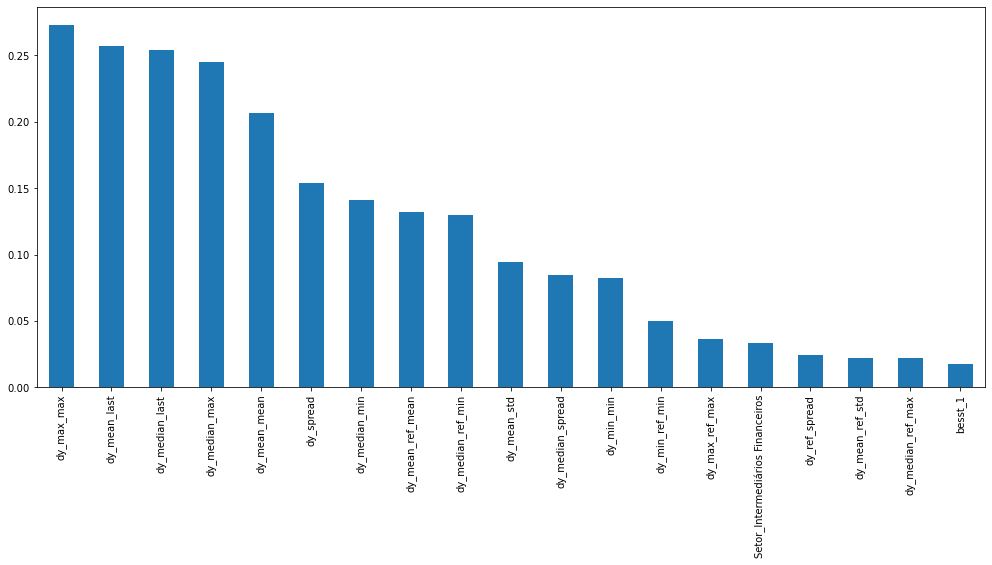

In [160]:
plt.figure(figsize=(17,7))
np.abs(cor).sort_values(ascending=False)[1:20].plot(kind='bar')

In [52]:
training_cols = np.abs(cor).sort_values(ascending=False)[0:100].index

In [53]:
df_to_train = df[['Empresa', 'Papel', 'year_month'] + list(training_cols)].copy()

In [54]:
df_to_train.sort_values(by='year_month', ascending=False)

,Empresa,Papel,year_month,dy_label,dy_max_max,dy_mean_last,dy_median_last,dy_median_max,dy_mean_mean,dy_spread,dy_median_min,dy_mean_ref_mean,dy_median_ref_min,dy_mean_std,dy_median_spread,dy_min_min,dy_min_ref_min,dy_max_ref_max,Setor_Intermediários Financeiros,dy_ref_spread,dy_mean_ref_std,dy_median_ref_max,besst_1,Setor_Químicos,Tipo_PN,Tipo_ON,dy_median_spread_relevance,dy_median_ref_spread,selic_std,selic_spread,selic_spread_relevance,cotacao_mean_mean,selic_max,Setor_Siderurgia e Metalurgia,"Setor_Tecidos, Vestuário e Calçados",cotacao_max_max,dolar_comercial_spread_relevance,Setor_Energia Elétrica,roe_max_max,cotacao_mean_ref_mean,liqc_min_min,besst_2,cotacao_min_min,cotacao_spread,cotacao_max_ref_max,year_last,Setor_Construção Civil,dolar_comercial_min,cotacao_min_ref_min,roe_spread,liq2m_max_max,cotacao_ref_spread,roe_mean_last,cotacao_mean_last,roe_mean_std,Setor_Material de Transporte,cotacao_mean_std,Setor_Alimentos Processados,Setor_Comércio,liq2m_mean_mean,Setor_Transporte,euro_min,"Setor_Petróleo, Gás e Biocombustíveis",dolar_comercial_last,liqc_mean_mean,Setor_Máquinas e Equipamentos,c5y_min_min,liq2m_spread,liq2m_mean_last,Setor_Exploração de Imóveis,dolar_comercial_max,Setor_Construção e Engenharia,c5y_min_ref_min,Setor_Comércio e Distribuição,liq2m_mean_std,cotacao_mean_ref_std,euro_max,Setor_Previdência e Seguros,liqc_mean_last,selic_last,Setor_Diversos,preco_do_petroleo_min,igpm_max,indice_da_industria_min,pib_dolarizado_min,igpm_spread,pib_dolarizado_spread,pib_dolarizado_spread_relevance,preco_do_petroleo_spread_relevance,ipca_spread_relevance,indice_da_industria_spread_relevance,igpm_spread_relevance,ibovespa_spread_relevance,indice_da_industria_spread,ibovespa_spread,preco_do_petroleo_spread,ipca_spread,ipca_min,ibovespa_min,Setor_Serv.Méd.Hospit. Análises e Diagnósticos,ibovespa_std,pib_dolarizado_std,indice_da_industria_std
91484,WESTWING ON NM,WEST3,2022.04.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0,0,1,0.000000,0.000000,0.019528,0.050788,1.161161,1.625112,0.050788,0,0,2.828768,1.099103,0,0.103399,0.219928,3.350000,0.0,1.000000,1.828768e+00,0.322738,2022.0,0,0.0000,0.152738,0.481409,1.469851e+06,0.170001,-0.283186,3.003097,0.149407,0,5.219146e-01,0,0,7.359318e+05,0,0.0000,0,4.9191,5.888733,0,-0.501345,1.306272e+06,1.698111e+06,0,5.4066,0,-8.255828,0,3.327020e+05,0.034345,5.56940,0,5.716428,0.043739,0,0.00,0.00,0.0,0.0,0.06,1544.9,1.0,1.0,1.0,1.0,-1.0,1.0,8.6,240413.5,0.92,0.84,0.00,0.0,0,93580.827956,601.351509,3.347545
56359,PETTENATI PN,PTNT4,2022.04.0,0.045183,0.061500,0.047450,0.047450,0.050134,0.048941,0.028300,0.047664,-7.033055,-17.766799,0.000983,0.002470,0.033200,-18.137028,9.087222,0,27.224250,9.355424,8.366666,0.0,0,1,0,0.052058,26.133466,0.019528,0.050788,1.161161,8.319210,0.050788,0,1,9.230551,1.099103,0,0.252500,1.081593,1.470000,0.0,5.180000,4.050551e+00,1.258281,2022.0,0,0.0000,0.794472,0.127800,3.446641e+05,0.463809,0.176171,7.385145,0.006959,0,5.113291e-01,0,0,1.571339e+05,0,0.0000,0,4.9191,1.623627,0,0.093405,2.969595e+05,7.695967e+04,0,5.4066,0,1.845502,0,1.063274e+05,0.141188,5.56940,0,1.568800,0.043739,0,0.00,0.00,0.0,0.0,0.06,1544.9,1.0,1.0,1.0,1.0,-1.0,1.0,8.6,240413.5,0.92,0.84,0.00,0.0,0,93580.827956,601.351509,3.347545
56001,PORTOBELLO S/A PN,PTBL4,2022.04.0,0.000007,0.000000,-0.000008,-0.000008,-0.000009,-0.000017,0.000026,-0.000026,0.001016,0.000676,0.000005,0.000017,-0.000026,0.000714,0.001190,0,0.000477,0.000201,0.001286,0.0,0,1,0,-2.189098,0.000610,0.019528,0.050788,1.161161,2.590000,0.050788,0,0,2.590000,1.099103,0,0.500900,0.907628,1.130000,0.0,2.590000,4.440892e-15,1.000000,2022.0,0,0.0000,0.683143,0.653189,0.000000e+00,0.316857,-0.018061,2.590000,0.035982,0,1.850506e-15,0,0,0.000000e+00,0,0.0000,0,4.9191,1.255074,0,-0.155630,0.000000e+00,0.000000e+00,0,5.4066,1,0.422041,0,0.000000e+00,0.124888,5.56940,0,1.277166,0.043739,0,0.00,0.00,0.0,

In [55]:
df_to_pred  = df_to_train[df_to_train['year_month']=='2022.04.0'].copy()
df = df_to_train[df_to_train['year_month']!='2022.04.0']

In [56]:
df['dy_label']

24       0.081976
25       0.081300
26       0.080631
27       0.079991
28       0.079338
           ...   
91379    0.000000
91405    0.000000
91431    0.000000
91457    0.000000
91483    0.000000
Name: dy_label, Length: 76247, dtype: float64

#### Spliting data into training a test data

features X_train: 99
features X_test: 99
R2 score: 0.48628737433034414
Mean squared error: 196.8934167327812
test score: 0.33920596342396236 
train score: 0.9999774445059978


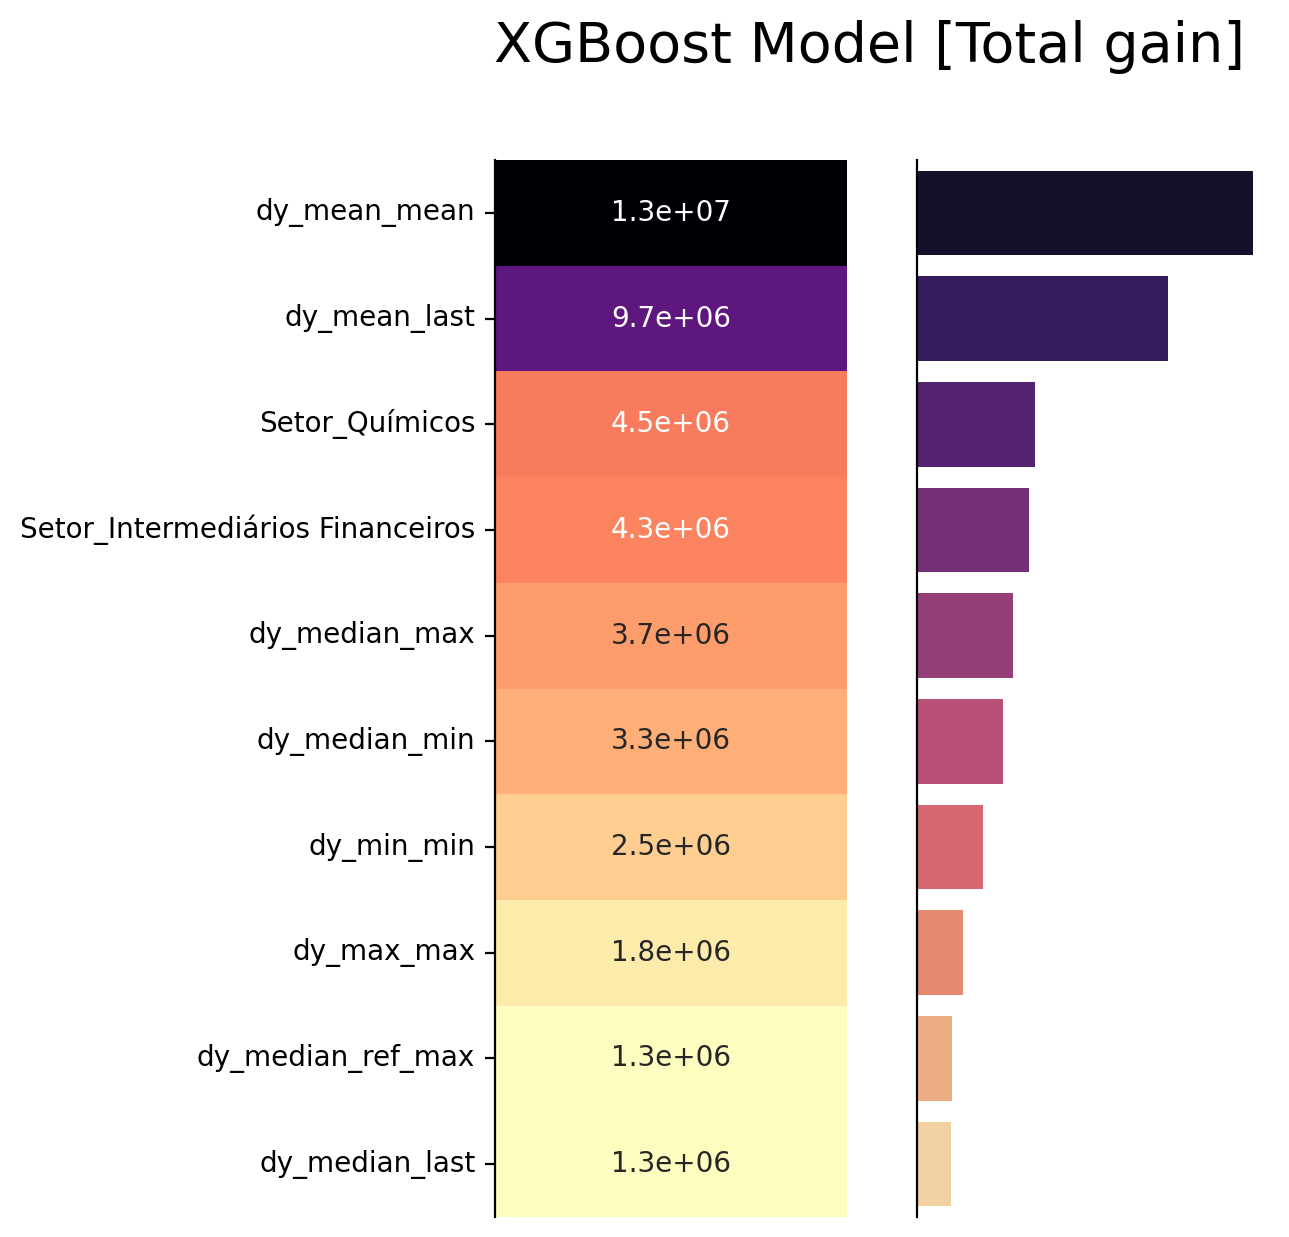

In [162]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()
df_to_pred
# separating the train and target features
X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
# X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

### Building a Machine Learning Pipeline 

In [58]:
def build_pipelines(regressors, transformers):
    pipelines = {}
    transformers = [Normalizer(), None]
    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [59]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [62]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance
    }

    patch = '../data/03_models/out/'
    filename = patch + algorithm

    # return performance

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+'.pkl', 'wb'))

    return test_score_r2



def main():

    # separating the train and target features
    X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
    y = df['dy_label']

    # X = df[training_features.index]
    # y = df['dy_label']

    regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }
    transformers = [Normalizer()]
    # transformers = [StandardScaler(), Normalizer()]

    with open('../data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm)
        print(algorithm, r2)

    return models


models = main()

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.01],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsampl

In [89]:
models

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                        ('reg', LGBMRegressor())]),
              param_grid={'reg__learning_rate': [0.1, 0.01],
                          'reg__n_estimators': [100, 500],
                          'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
              scoring='r2'),
 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                               

In [166]:
def load_model(path, model_name):
    
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break

    return loaded_model


path = '../data/03_models/out/'

model_name = 'LGBMRegressor_Normalizer().pkl'

lgb_model = load_model(path, model_name)


model_name = 'XGBRegressor_Normalizer().pkl'

xgb_model = load_model(path, model_name)


In [140]:
xgb_model.get_booster().get_score(importance_type='gain').values()

dict_values([11330.6767578125, 73968.671875, 58422.43359375, 108458.640625, 186954.375, 31859.013671875, 60092.140625, 1517.791259765625, 14805.6025390625, 25107.384765625, 16981.0390625, 12207.6796875, 308134.8125, 12909.044921875, 344778.9375, 2535.635986328125, 1502.341796875, 14270.2939453125, 504751.59375, 11167.142578125, 30938.0, 3221.666015625, 36058.2578125, 521572.625, 8217.451171875, 1089868.5, 59222.62109375, 13263.65234375, 435666.0, 6186.75927734375, 4920.49072265625, 11937.2509765625, 3508.486572265625, 5862.267578125, 61715.09375, 0.04602810740470886, 12051.451171875, 8133.884765625, 943.4235229492188, 1325.9945068359375, 18120.857421875, 16014.501953125, 323966.5, 8062.97998046875, 14606.80859375, 6192.13037109375, 198314.28125, 33199.359375, 7517.8359375, 52892.32421875, 1896.8995361328125, 5093.66064453125])

In [151]:
def get_feature_importances(model, model_class, features):
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance



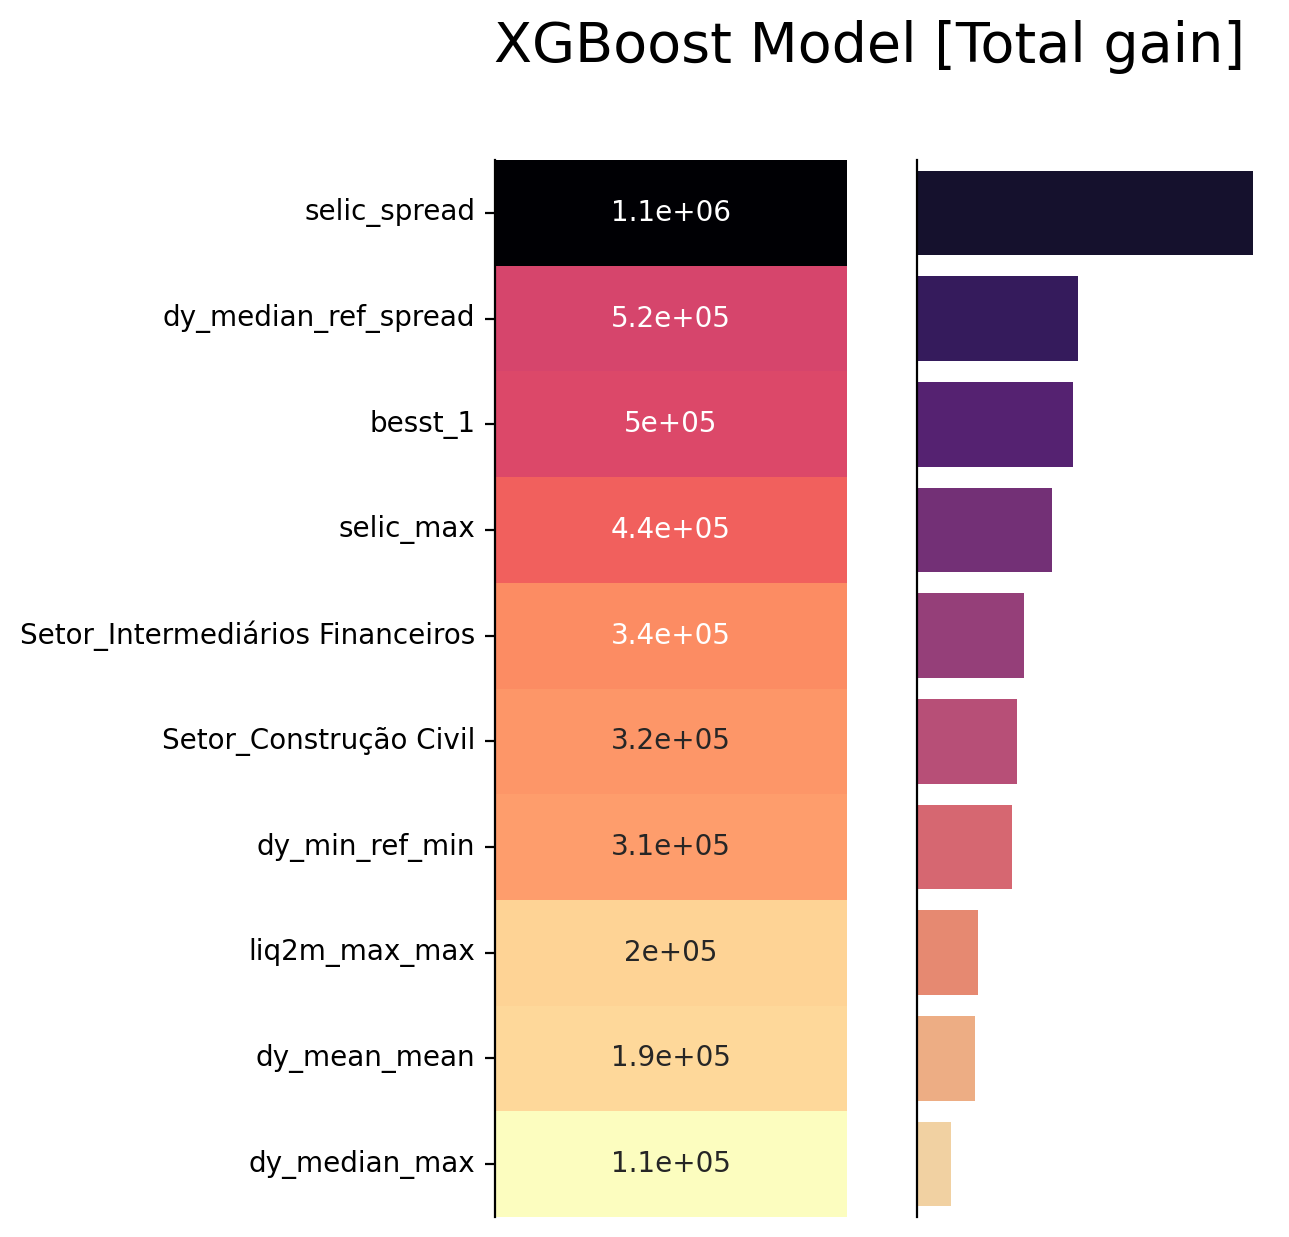

In [167]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X_train.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

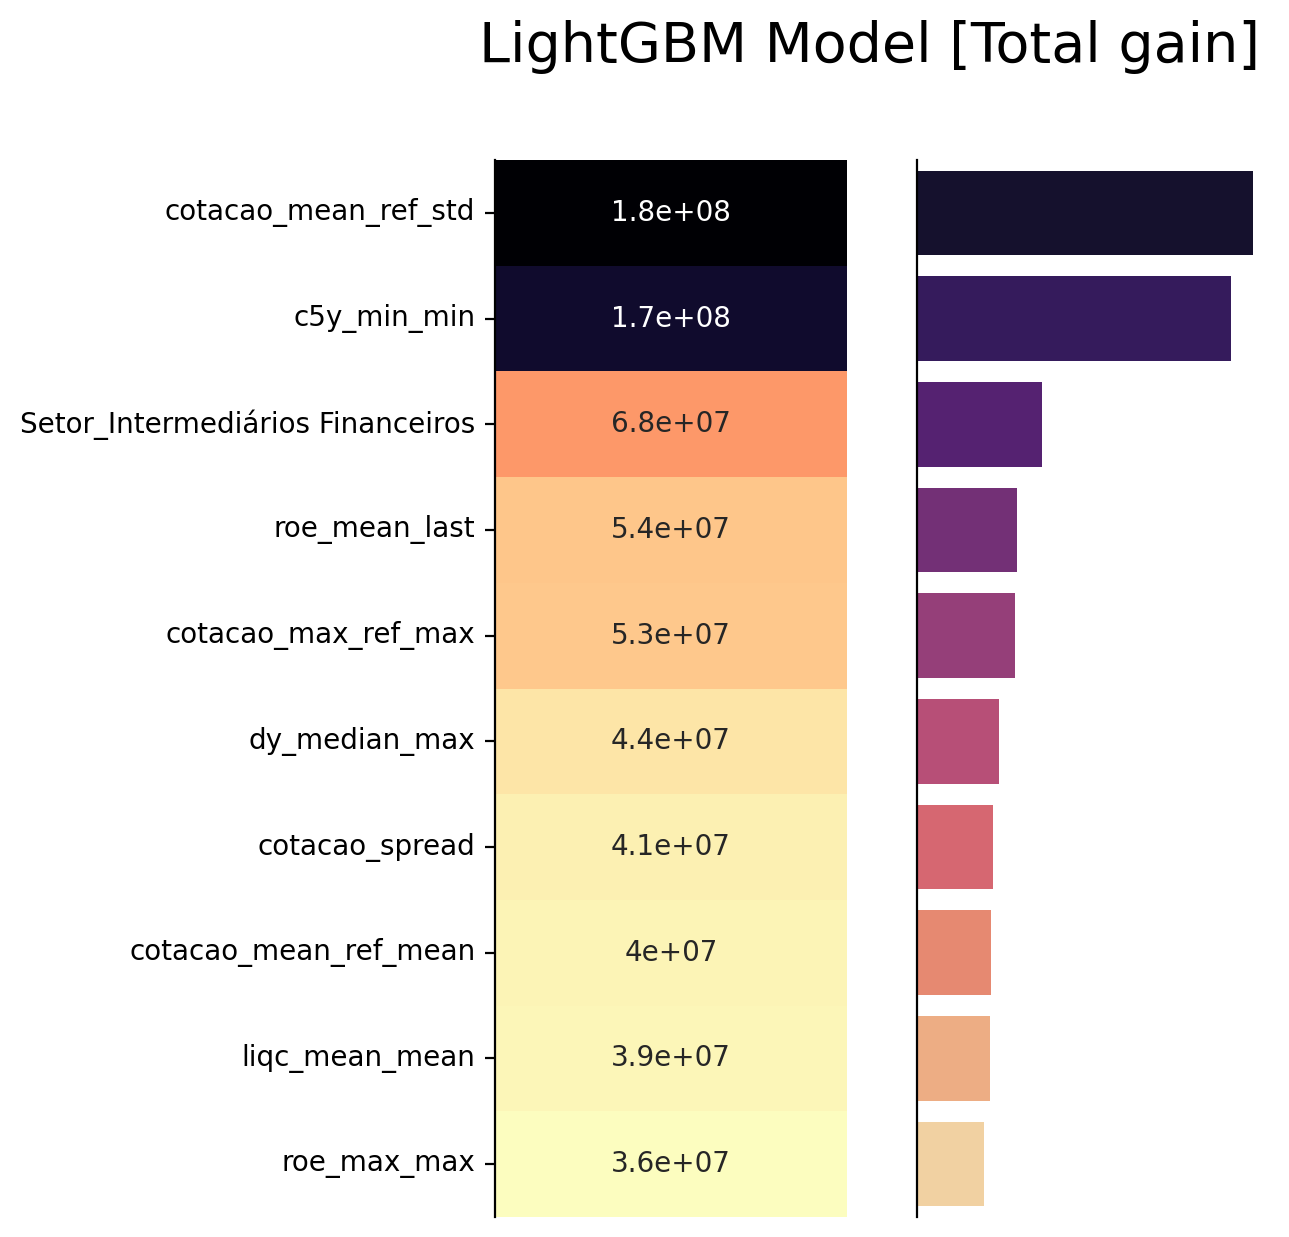

In [168]:
lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X_train.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

In [72]:
def calculate_shap_values(model, X_train, X_test):
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, X_train)

        # Calculate SHAP values for the test data
        shap_values = explainer(X_test)

        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")


path = '../data/03_models/out/'

xgb_shap = calculate_shap_values(xgb_model, X_train, X_test)
file_name = 'XGBRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(xgb_shap, file)


lgb_shap = calculate_shap_values(lgb_model, X_train, X_test)
file_name = 'LGBMRegressor_Normalizer()_SHAP.pkl'

# Save SHAP values to a file using pickle
with open(path + file_name, 'wb') as file:
    pickle.dump(lgb_shap, file)
    

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 22876it [58:47,  6.47it/s]                            


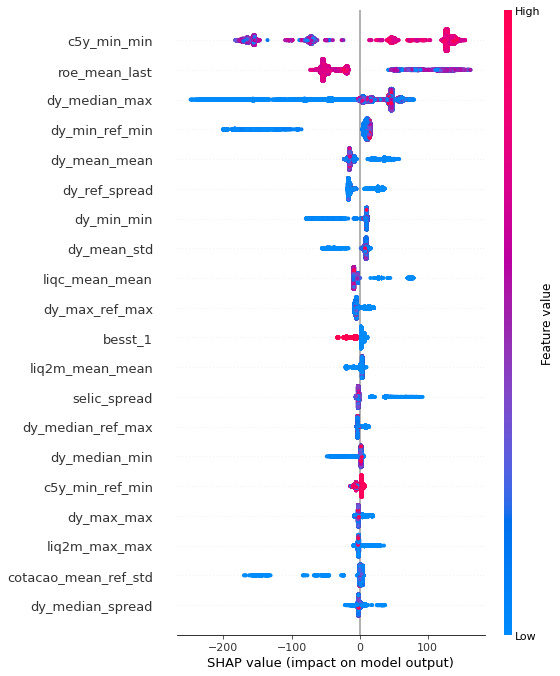

In [81]:
shap.summary_plot(lgb_shap, X_test)

In [ ]:
shap.summary_plot(xgb_shap, X_test)

In [170]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [173]:
df_to_pred['dy_pred'] = xgb_model.predict(X_to_pred)

In [176]:
df_to_pred.sort_values(by='dy_pred', ascending=False).iloc[0:20]

,Empresa,Papel,year_month,dy_label,dy_max_max,dy_mean_last,dy_median_last,dy_median_max,dy_mean_mean,dy_spread,dy_median_min,dy_mean_ref_mean,dy_median_ref_min,dy_mean_std,dy_median_spread,dy_min_min,dy_min_ref_min,dy_max_ref_max,Setor_Intermediários Financeiros,dy_ref_spread,dy_mean_ref_std,dy_median_ref_max,besst_1,Setor_Químicos,Tipo_PN,Tipo_ON,dy_median_spread_relevance,dy_median_ref_spread,selic_std,selic_spread,selic_spread_relevance,cotacao_mean_mean,selic_max,Setor_Siderurgia e Metalurgia,"Setor_Tecidos, Vestuário e Calçados",cotacao_max_max,dolar_comercial_spread_relevance,Setor_Energia Elétrica,roe_max_max,cotacao_mean_ref_mean,liqc_min_min,besst_2,cotacao_min_min,cotacao_spread,cotacao_max_ref_max,year_last,Setor_Construção Civil,dolar_comercial_min,cotacao_min_ref_min,roe_spread,liq2m_max_max,cotacao_ref_spread,roe_mean_last,cotacao_mean_last,roe_mean_std,Setor_Material de Transporte,cotacao_mean_std,Setor_Alimentos Processados,Setor_Comércio,liq2m_mean_mean,Setor_Transporte,euro_min,"Setor_Petróleo, Gás e Biocombustíveis",dolar_comercial_last,liqc_mean_mean,Setor_Máquinas e Equipamentos,c5y_min_min,liq2m_spread,liq2m_mean_last,Setor_Exploração de Imóveis,dolar_comercial_max,Setor_Construção e Engenharia,c5y_min_ref_min,Setor_Comércio e Distribuição,liq2m_mean_std,cotacao_mean_ref_std,euro_max,Setor_Previdência e Seguros,liqc_mean_last,selic_last,Setor_Diversos,preco_do_petroleo_min,igpm_max,indice_da_industria_min,pib_dolarizado_min,igpm_spread,pib_dolarizado_spread,pib_dolarizado_spread_relevance,preco_do_petroleo_spread_relevance,ipca_spread_relevance,indice_da_industria_spread_relevance,igpm_spread_relevance,ibovespa_spread_relevance,indice_da_industria_spread,ibovespa_spread,preco_do_petroleo_spread,ipca_spread,ipca_min,ibovespa_min,Setor_Serv.Méd.Hospit. Análises e Diagnósticos,ibovespa_std,pib_dolarizado_std,indice_da_industria_std,dy_pred
72012,UOL PN,UOLL4,2022.04.0,0.000121,0.000376,0.000232,0.000232,0.000372,0.000303,0.000376,0.000243,1.849443,0.605732,0.000040,0.000129,0.000000,0.000000,2.928059,0,2.928059,1.439249,4.741850,0.0,0,1,0,0.557123,4.136118,0.019528,0.050788,1.161161,18.535637,0.050788,0,0,19.620000,1.099103,0,0.084821,2.623829,1.010000,0.0,18.407649,1.212351,3.462226,2022.0,0,0.0,2.042198,0.030821,0.000000e+00,1.420028,0.073068,18.658738,0.003224,0,0.064903,0,0,-7.102856e-03,0,0.0,0,4.9191,1.988151,0,0.187169,1.140888e-02,-2.908178e-03,0,5.4066,0,1.198489,0,0.000000e+00,0.436459,5.5694,0,1.762617,0.043739,0,0.0,0.0,0.0,0.0,0.06,1544.9,1.0,1.0,1.0,1.0,-1.0,1.0,8.6,240413.5,0.92,0.84,0.0,0.0,0,93580.827956,601.351509,3.347545,1493.170532
10202,Bovespa Hld ON NM,BOVH3,2022.04.0,0.000163,0.000457,0.000293,0.000293,0.000452,0.000373,0.000457,0.000305,0.037094,0.034855,0.000045,0.000147,0.000000,0.000000,0.039651,0,0.039651,0.001688,0.039977,0.0,0,0,1,0.503208,0.005122,0.019528,0.050788,1.161161,16.053706,0.050788,0,0,16.132411,1.099103,0,0.000000,2.508499,4.380824,1.0,15.710000,0.422411,2.689612,2022.0,0,0.0,2.172570,0.000000,0.000000e+00,0.517042,0.000000,15.977207,0.000000,0,0.042444,0,0,-4.361058e-03,0,0.0,0,4.9191,4.384319,0,0.000000,7.004038e-03,-1.786380e-03,0,5.4066,0,0.000000,0,2.793371e+00,0.173122,5.5694,0,4.387713,0.043739,0,0.0,0.0,0.0,0.0,0.06,1544.9,1.0,1.0,1.0,1.0,-1.0,1.0,8.6,240413.5,0.92,0.84,0.0,0.0,0,93580.827956,601.351509,3.347545,1477.493042
81383,RAIA ON NM,RAIA3,2022.04.0,0.000091,0.000331,0.000194,0.000194,0.000327,0.000261,0.000331,0.000204,0.027596,0.025787,0.000038,0.000123,0.000000,0.000000,0.029975,0,0.029975,0.001446,0.030966,0.0,0,0,1,0.634152,0.005179,0.019528,0.050788,1.161161,29.822448,0.050788,0,0,30.500000,1.099103,0,0.072200,1.690212,2.188544,0.0,29.648344,0.851656,2.051110,2022.0,0,0.0,1.603972,0.006336,7.279113e-03,0.447138,0.068405,29.992378,0.000700,0,0.094815,0,0,4.367335e-03,0,0.0,0,4.9191,2.190845,0,0.000000,7.279113e-03,1.538686e-03,0,5.4066,0,0.000000,1,0.000000e+00,0.138078,5.5694,0,2.193090,0.043739,0,0.0,0.0,0.0,0.0,0.06,1544.9,1.0,1.0,1.0,1.0,-1

# Feature selection

In [178]:
i=30
df.columns[i:i+30]

Index(['selic_spread_relevance', 'cotacao_mean_mean', 'selic_max',
       'Setor_Siderurgia e Metalurgia', 'Setor_Tecidos, Vestuário e Calçados',
       'cotacao_max_max', 'dolar_comercial_spread_relevance',
       'Setor_Energia Elétrica', 'roe_max_max', 'cotacao_mean_ref_mean',
       'liqc_min_min', 'besst_2', 'cotacao_min_min', 'cotacao_spread',
       'cotacao_max_ref_max', 'year_last', 'Setor_Construção Civil',
       'dolar_comercial_min', 'cotacao_min_ref_min', 'roe_spread',
       'liq2m_max_max', 'cotacao_ref_spread', 'roe_mean_last',
       'cotacao_mean_last', 'roe_mean_std', 'Setor_Material de Transporte',
       'cotacao_mean_std', 'Setor_Alimentos Processados', 'Setor_Comércio',
       'liq2m_mean_mean'],
      dtype='object')

In [179]:
i=60
df.columns[i:i+30]

Index(['Setor_Transporte', 'euro_min', 'Setor_Petróleo, Gás e Biocombustíveis',
       'dolar_comercial_last', 'liqc_mean_mean',
       'Setor_Máquinas e Equipamentos', 'c5y_min_min', 'liq2m_spread',
       'liq2m_mean_last', 'Setor_Exploração de Imóveis', 'dolar_comercial_max',
       'Setor_Construção e Engenharia', 'c5y_min_ref_min',
       'Setor_Comércio e Distribuição', 'liq2m_mean_std',
       'cotacao_mean_ref_std', 'euro_max', 'Setor_Previdência e Seguros',
       'liqc_mean_last', 'selic_last', 'Setor_Diversos',
       'preco_do_petroleo_min', 'igpm_max', 'indice_da_industria_min',
       'pib_dolarizado_min', 'igpm_spread', 'pib_dolarizado_spread',
       'pib_dolarizado_spread_relevance', 'preco_do_petroleo_spread_relevance',
       'ipca_spread_relevance'],
      dtype='object')

In [180]:
i=90
df.columns[i:i+30]

Index(['indice_da_industria_spread_relevance', 'igpm_spread_relevance',
       'ibovespa_spread_relevance', 'indice_da_industria_spread',
       'ibovespa_spread', 'preco_do_petroleo_spread', 'ipca_spread',
       'ipca_min', 'ibovespa_min',
       'Setor_Serv.Méd.Hospit. Análises e Diagnósticos', 'ibovespa_std',
       'pib_dolarizado_std', 'indice_da_industria_std'],
      dtype='object')

In [181]:
i=120
df.columns[i:i+30]

Index([], dtype='object')